# Semi-supervised AQI Classification — Self-Training

- Mục tiêu: chạy self-training để **tăng lượng nhãn** cho AQI khi thiếu nhãn.
- Output: metrics JSON + sample predictions + sample alerts.
- Mini project: sweep TAU / LABEL_MISSING_FRACTION và so sánh với baseline supervised.

In [3]:
SEMI_DATASET_PATH = "data/processed/dataset_for_semi.parquet"
CUTOFF = "2017-01-01"

TAU = 0.90
MAX_ITER = 10
MIN_NEW_PER_ITER = 20
VAL_FRAC = 0.20
RANDOM_STATE = 42

METRICS_PATH = "data/processed/metrics_self_training.json"
PRED_SAMPLE_PATH = "data/processed/predictions_self_training_sample.csv"
ALERTS_SAMPLE_PATH = "data/processed/alerts_self_training_sample.csv"
ALERT_FROM_CLASS = "Unhealthy"

Dataset shape: (420768, 56)
Labeled samples: 36485
Running Self-Training with TAU = 0.9 ...


,iter,val_accuracy,val_f1_macro,unlabeled_pool,new_pseudo,tau
0,1,0.722615,0.679270,383962,76134,0.9
1,2,0.713781,0.678319,307828,202713,0.9
2,3,0.706461,0.672945,105115,45622,0.9
3,4,0.700151,0.665001,59493,12716,0.9
4,5,0.695356,0.655768,46777,5519,0.9
5,6,0.670116,0.624643,41258,1660,0.9
6,7,0.690056,0.650048,39598,2953,0.9
7,8,0.663806,0.612969,36645,587,0.9
8,9,0.701161,0.664477,36058,1762,0.9
9,10,0.666835,0.617609,34296,353,0.9



=== TEST RESULTS ===
Test accuracy: 0.589046847819567
Test f1_macro: 0.5343258092284096


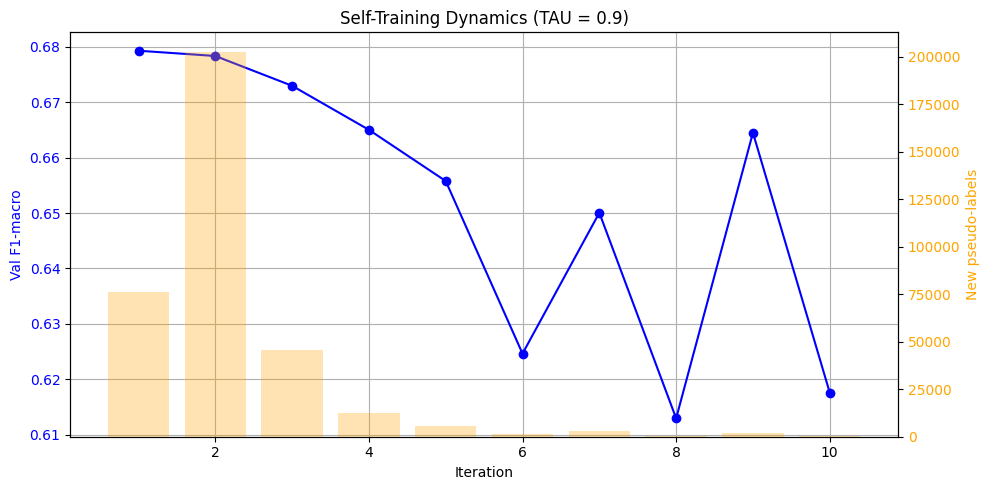


Saved: D:\Mini_7\air_guard-main\data\processed\metrics_self_training.json
Saved: D:\Mini_7\air_guard-main\data\processed\predictions_self_training_sample.csv
Saved: D:\Mini_7\air_guard-main\data\processed\alerts_self_training_sample.csv


In [5]:
import sys
import importlib
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_ROOT = Path(".").resolve()
if not (PROJECT_ROOT / "data").exists() and (PROJECT_ROOT.parent / "data").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent.resolve()

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Reload module to get latest changes
import src.semi_supervised_library as ssl_module
importlib.reload(ssl_module)

from src.semi_supervised_library import (
    SemiDataConfig, SelfTrainingConfig, run_self_training, add_alert_columns
)

df = pd.read_parquet((PROJECT_ROOT / SEMI_DATASET_PATH).resolve())

# Convert aqi_class to object dtype to handle np.nan properly
if "aqi_class" in df.columns:
    df["aqi_class"] = df["aqi_class"].astype("object")
    df["aqi_class"] = df["aqi_class"].where(pd.notna(df["aqi_class"]), np.nan)

data_cfg = SemiDataConfig(cutoff=CUTOFF, random_state=int(RANDOM_STATE))
st_cfg = SelfTrainingConfig(
    tau=float(TAU),
    max_iter=int(MAX_ITER),
    min_new_per_iter=int(MIN_NEW_PER_ITER),
    val_frac=float(VAL_FRAC),
)

print("Dataset shape:", df.shape)
print("Labeled samples:", df["is_labeled"].sum() if "is_labeled" in df.columns else "N/A")
print("Running Self-Training with TAU =", TAU, "...")

out = run_self_training(df, data_cfg, st_cfg)
history = pd.DataFrame(out["history"])
pred_df = out["pred_df"]
test_metrics = out["test_metrics"]

display(history)
print("\n=== TEST RESULTS ===")
print("Test accuracy:", test_metrics["accuracy"])
print("Test f1_macro:", test_metrics["f1_macro"])

# Plot dynamics
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(history["iter"], history["val_f1_macro"], marker="o", color="blue", label="Val F1-macro")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Val F1-macro", color="blue")
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.bar(history["iter"], history["new_pseudo"], alpha=0.3, color="orange", label="New pseudo-labels")
ax2.set_ylabel("New pseudo-labels", color="orange")
ax2.tick_params(axis='y', labelcolor='orange')

plt.title("Self-Training Dynamics (TAU = {})".format(TAU))
fig.tight_layout()
plt.show()

# Save artifacts
metrics_path = (PROJECT_ROOT / METRICS_PATH).resolve()
pred_path = (PROJECT_ROOT / PRED_SAMPLE_PATH).resolve()
alerts_path = (PROJECT_ROOT / ALERTS_SAMPLE_PATH).resolve()
for p in [metrics_path, pred_path, alerts_path]:
    p.parent.mkdir(parents=True, exist_ok=True)

payload = {
    "method": "self_training",
    "data_cfg": data_cfg.__dict__,
    "st_cfg": st_cfg.__dict__,
    "history": out["history"],
    "test_metrics": test_metrics,
    "model_info": out["model_info"],
}
with open(metrics_path, "w", encoding="utf-8") as f:
    json.dump(payload, f, ensure_ascii=False, indent=2)

pred_df.head(5000).to_csv(pred_path, index=False)
alerts = add_alert_columns(pred_df, pred_col="y_pred", severe_from=ALERT_FROM_CLASS)
alerts.head(5000).to_csv(alerts_path, index=False)

print("\nSaved:", metrics_path)
print("Saved:", pred_path)
print("Saved:", alerts_path)

## Thử nghiệm với các giá trị TAU khác nhau (BẮT BUỘC)

Theo yêu cầu, ta cần thử nghiệm với ít nhất một giá trị τ khác để so sánh hiệu quả.


Testing TAU = 0.8
Test Accuracy: 0.5941
Test F1-macro: 0.5167

Testing TAU = 0.9
Test Accuracy: 0.5890
Test F1-macro: 0.5343

Testing TAU = 0.95
Test Accuracy: 0.5931
Test F1-macro: 0.5330

SO SÁNH KẾT QUẢ VỚI CÁC GIÁ TRỊ TAU KHÁC NHAU


,TAU,Test Accuracy,Test F1-macro,Total Iterations,Total Pseudo-labels
0,0.80,0.594086,0.516688,10,364388
1,0.90,0.589047,0.534326,10,350019
2,0.95,0.593066,0.532986,10,314834


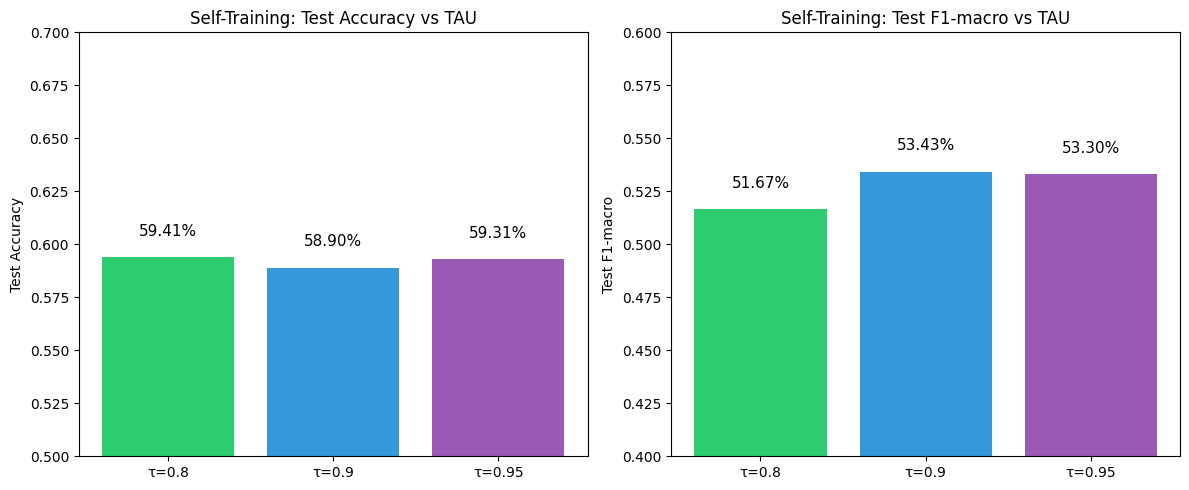


📊 NHẬN XÉT:
- Giá trị TAU tốt nhất (theo F1-macro): τ = 0.9
- TAU thấp (0.8): Mô hình tự tin hơn → thêm nhiều pseudo-labels hơn → có thể gây nhiễu
- TAU cao (0.95): Mô hình thận trọng hơn → ít pseudo-labels → ít cải thiện
- TAU = 0.9: Cân bằng giữa số lượng và chất lượng pseudo-labels


In [1]:
# Thử nghiệm với các giá trị TAU khác nhau
import sys
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_ROOT = Path(".").resolve()
if not (PROJECT_ROOT / "data").exists() and (PROJECT_ROOT.parent / "data").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent.resolve()

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.semi_supervised_library import (
    SemiDataConfig, SelfTrainingConfig, run_self_training
)

# Load data
SEMI_DATASET_PATH = "data/processed/dataset_for_semi.parquet"
CUTOFF = "2017-01-01"
RANDOM_STATE = 42

df = pd.read_parquet((PROJECT_ROOT / SEMI_DATASET_PATH).resolve())
if "aqi_class" in df.columns:
    df["aqi_class"] = df["aqi_class"].astype("object")
    df["aqi_class"] = df["aqi_class"].where(pd.notna(df["aqi_class"]), np.nan)

data_cfg = SemiDataConfig(cutoff=CUTOFF, random_state=RANDOM_STATE)

# Test different TAU values
TAU_VALUES = [0.8, 0.9, 0.95]
results_tau = []

for tau in TAU_VALUES:
    print(f"\n{'='*60}")
    print(f"Testing TAU = {tau}")
    print(f"{'='*60}")
    
    st_cfg = SelfTrainingConfig(
        tau=tau,
        max_iter=10,
        min_new_per_iter=20,
        val_frac=0.20,
    )
    
    out = run_self_training(df.copy(), data_cfg, st_cfg)
    test_metrics = out["test_metrics"]
    history = out["history"]
    
    results_tau.append({
        "TAU": tau,
        "Test Accuracy": test_metrics["accuracy"],
        "Test F1-macro": test_metrics["f1_macro"],
        "Total Iterations": len(history),
        "Total Pseudo-labels": sum(h["new_pseudo"] for h in history)
    })
    
    print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Test F1-macro: {test_metrics['f1_macro']:.4f}")

# Create comparison table
results_df = pd.DataFrame(results_tau)
print("\n" + "="*70)
print("SO SÁNH KẾT QUẢ VỚI CÁC GIÁ TRỊ TAU KHÁC NHAU")
print("="*70)
display(results_df)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

colors = ['#2ecc71', '#3498db', '#9b59b6']
x = range(len(results_df))

axes[0].bar(x, results_df["Test Accuracy"], color=colors)
axes[0].set_xticks(x)
axes[0].set_xticklabels([f"τ={t}" for t in results_df["TAU"]])
axes[0].set_ylabel("Test Accuracy")
axes[0].set_title("Self-Training: Test Accuracy vs TAU")
axes[0].set_ylim(0.5, 0.7)
for i, v in enumerate(results_df["Test Accuracy"]):
    axes[0].text(i, v + 0.01, f'{v:.2%}', ha='center', fontsize=11)

axes[1].bar(x, results_df["Test F1-macro"], color=colors)
axes[1].set_xticks(x)
axes[1].set_xticklabels([f"τ={t}" for t in results_df["TAU"]])
axes[1].set_ylabel("Test F1-macro")
axes[1].set_title("Self-Training: Test F1-macro vs TAU")
axes[1].set_ylim(0.4, 0.6)
for i, v in enumerate(results_df["Test F1-macro"]):
    axes[1].text(i, v + 0.01, f'{v:.2%}', ha='center', fontsize=11)

plt.tight_layout()
plt.show()

# Nhận xét
best_tau = results_df.loc[results_df["Test F1-macro"].idxmax(), "TAU"]
print(f"\n📊 NHẬN XÉT:")
print(f"- Giá trị TAU tốt nhất (theo F1-macro): τ = {best_tau}")
print(f"- TAU thấp (0.8): Mô hình tự tin hơn → thêm nhiều pseudo-labels hơn → có thể gây nhiễu")
print(f"- TAU cao (0.95): Mô hình thận trọng hơn → ít pseudo-labels → ít cải thiện")
print(f"- TAU = 0.9: Cân bằng giữa số lượng và chất lượng pseudo-labels")